In [4]:
import pathlib

import torch
import scipy
import torchaudio
import s3prl.hub

import numpy as np
import matplotlib.pyplot as plt

from wav2avatar.inversion.linear_inversion import EMADataset

import wav2avatar.streaming.hifigan.collate as wav_ema_collate
from wav2avatar.streaming.hifigan.hifigan_generator import HiFiGANGenerator
device = 0

In [ ]:
device = 0
gen = HiFiGANGenerator(
    in_channels=512, 
    out_channels=12, 
    ar_input=600, 
    use_tanh=False,
    use_mlp_ar=False,
    resblock_kernel_sizes=(3, 7, 11, 15, 19),
    resblock_dilations=[(1, 3, 5), (1, 3, 5), (1, 3, 5), (1, 3, 5), (1, 3, 5)],
                       ).to(device)

gen.load_state_dict(torch.load('ckpts/hfcar_l1_noup_5res_arconv3_90_0.84.pth')["gen_state_dict"])

def unroll_collated(features):
    return torch.concatenate(list(features), dim=1)

@torch.no_grad()
def eval_gen(batch):
    x = batch[0].to(device)
    y = batch[1].to(device)
    y_unrolled = unroll_collated(y)

    ar = torch.zeros((1, 12, 50)).to(device)
    pred = []
    for audio_feat in x:
        pred.append(gen(audio_feat.unsqueeze(0), ar)[:, :, :50])
        ar = pred[-1][:, :, :50]

    full_pred = torch.concatenate(pred, dim=2).squeeze(0)
    full_pred = full_pred.transpose(1, 0).cpu().numpy()
    y_unrolled = y_unrolled.transpose(1, 0).cpu().numpy()
    corrs = []
    for i in range(12):
        corrs.append(scipy.stats.pearsonr(full_pred[:, i], y_unrolled[:, i])[0])
    print("Correlations:", np.mean(corrs))
    return full_pred, y_unrolled

feature_model = getattr(s3prl.hub, "wavlm_large")()
feature_model = feature_model.model.feature_extractor.to(device)

@torch.no_grad()
def eval_audio(audio, true_ema):
    ar = torch.zeros((1, 12, 50)).to(device)

    audio_feats = feature_model(audio.to(device))
    collated_audio = wav_ema_collate.collate_features(audio_feats.unsqueeze(0))
    pred = []
    for audio_feat in collated_audio:
        #print(audio_feat.shape, ar.shape)
        pred.append(gen(audio_feat.unsqueeze(0), ar)[:, :, :])
        ar = pred[-1][:, :, :]
    full_pred = torch.concatenate(pred, dim=2).squeeze(0)
    #print(full_pred.shape)
    full_pred = full_pred.transpose(1, 0).cpu().numpy()

    return full_pred

def mngu0_to_hprc(arr):
    arr_td = arr[:, 0:2]

    arr_tb = arr[:, 2:4]

    arr_tt = arr[:, 4:6]

    arr_li = arr[:, 6:8] # locked

    arr_ul = arr[:, 8:10] # locked

    arr_ll = arr[:, 10:12] # locked

    arr[:, 0] = arr_li[:, 0] * -1
    arr[:, 1] = arr_li[:, 1]
    arr[:, 2] = arr_ul[:, 0] * -1
    arr[:, 3] = arr_ul[:, 1]
    arr[:, 4] = arr_ll[:, 0] * -1
    arr[:, 5] = arr_ll[:, 1]
    arr[:, 6] = arr_tt[:, 0] * -1
    arr[:, 7] = arr_tt[:, 1]
    arr[:, 8] = arr_tb[:, 0] * -1
    arr[:, 9] = arr_tb[:, 1]
    arr[:, 10] = arr_td[:, 0] * -1
    arr[:, 11] = arr_td[:, 1]


audio_file = "../../inversion/wav/mngu0_s1_1165.wav"
ema_file = "../../inversion/ema/mngu0_s1_1165_gt.npy"

audio, sr = torchaudio.load("../../inversion/wav/mngu0_s1_1165.wav")
#audio, sr = torchaudio.load(audio_file)
audio = torchaudio.functional.resample(
    audio, orig_freq=sr, new_freq=16000
)[0].unsqueeze(0)
#audio = torch.concatenate([audio, audio], dim=1)
#print(audio.shape)
true_ema = np.load("../../inversion/ema/mngu0_s1_1165_gt.npy")
true_ema = EMADataset.downsample_by_mean(true_ema, int(200 / 50))
true_ema = EMADataset.butter_bandpass_filter(true_ema, 10, 50)
mngu0_to_hprc(true_ema)
pred_ema = eval_audio(audio, true_ema)
true_ema = true_ema[:len(pred_ema)]

Feature corr: PearsonRResult(statistic=0.8498651293046753, pvalue=6.072175714609761e-71)


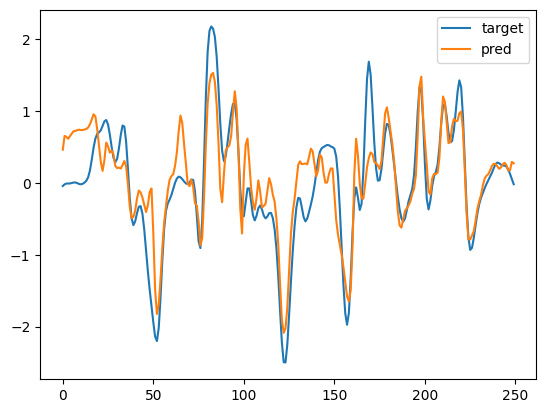

In [50]:
feat_num = 5
plt.plot(true_ema[:, feat_num], label="target")
plt.plot(pred_ema[:, feat_num], label="pred")
plt.legend()
print("Feature corr:", scipy.stats.pearsonr(pred_ema[:len(pred_ema), feat_num], true_ema[:len(pred_ema), feat_num]))

In [36]:
parts = ["li", "ul", "ll", "tt", "tb", "td"]
def get_flattened_range(arr, start, end):
    dim = arr[:, start:end]
    dim = list(dim.reshape(len(dim),))
    return dim

def get_corrs_npy(ground_truth, predicted, lower_hz=False, get_traces=False):

    if lower_hz:
        ground_truth = lower_hz(ground_truth)
    min_length = min(len(ground_truth), len(predicted))
    ground_truth = ground_truth[:min_length]
    predicted = predicted[:min_length]

    gt_parts = []
    p_parts = []

    for i in range(0, 12):
        gt_parts.append(get_flattened_range(ground_truth, i, i + 1))
        p_parts.append(get_flattened_range(predicted, i, i + 1))
    

    corrs = []
    corr_dict = {}

    for part in parts:
        corr_dict[part] = []

    for i in range(12):
        corr = scipy.stats.pearsonr(gt_parts[i], p_parts[i])
        corrs.append(corr.statistic)
        corr_dict[parts[i // 2]].append(round(corr.statistic, 3))

    if get_traces:
        return corr_dict, gt_parts, p_parts
    else:
        return corr_dict, np.array(corrs)

In [37]:
corr_dict, corrs = get_corrs_npy(true_ema, pred_ema)

In [52]:
corrs.shape

(12,)

In [1]:
with open("../../../../mngu0/split/test.txt", "r") as f:
    lines = f.readlines()
lines = [line[:-1] for line in lines]

In [2]:
mngu0_root = pathlib.Path("C:\\Users\\tejas\\Documents\\UCBerkeley\\bci\\mngu0\\")

with open(mngu0_root / "split" / "test.txt", "r") as f:
    lines = f.readlines()
lines = [line[:-1] for line in lines]

NameError: name 'pathlib' is not defined

In [91]:
def get_gen_corrs(audio_file, ema_file):
    audio, sr = torchaudio.load(audio_file)
    audio = torchaudio.functional.resample(
        audio, orig_freq=sr, new_freq=16000
    )[0].unsqueeze(0)
    true_ema = np.load(ema_file)
    true_ema = EMADataset.downsample_by_mean(true_ema, int(200 / 50))
    true_ema = EMADataset.butter_bandpass_filter(true_ema, 10, 50)
    mngu0_to_hprc(true_ema)
    pred_ema = eval_audio(audio, true_ema)
    true_ema = true_ema[:len(pred_ema)]
    
    _, corrs = get_corrs_npy(true_ema, pred_ema)

    return corrs

mngu0_root = pathlib.Path("C:\\Users\\tejas\\Documents\\UCBerkeley\\bci\\mngu0\\")
wav_root = mngu0_root / "wav"
ema_root = mngu0_root / "ema"

with open(mngu0_root / "split" / "test.txt", "r") as f:
    lines = f.readlines()
lines = [line[:-1] for line in lines]

corrs = np.zeros((12,))
from tqdm import tqdm
for line in tqdm(lines):
    audio_file = wav_root / f"{line}.wav"
    ema_file = ema_root / f"{line}.npy"

    corrs += get_gen_corrs(audio_file, ema_file)

corrs /= len(lines)

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:04<00:00, 25.97it/s]


In [92]:
corr_dict = {parts[i // 2]: list(corrs[i:i+2].round(3)) for i in range(0, 11, 2)}

In [93]:
np.mean(corrs)

0.7838962934256478

In [94]:
import pprint
print(f"CNN-CAR HiFiCAR Correlations on MNGU0 Test Set:\nAverage: {np.mean(corrs).round(3)} +- {np.std(corrs).round(3)}")
pprint.pprint(corr_dict)

CNN-CAR HiFiCAR Correlations on MNGU0 Test Set:
Average: 0.784 +- 0.044
{'li': [0.786, 0.858],
 'll': [0.789, 0.807],
 'tb': [0.73, 0.736],
 'td': [0.787, 0.857],
 'tt': [0.789, 0.807],
 'ul': [0.725, 0.735]}


In [72]:
corrs

array([0.78635434, 0.85812034, 0.72506983, 0.73480505, 0.78896194,
       0.80672821, 0.78898563, 0.80700815, 0.73026367, 0.73628063,
       0.78700402, 0.85717372])